In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os

# 하이퍼파라미터
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 7

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # FER2013은 흑백
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = ImageFolder(root=r'C:\Users\hyi8402\Desktop\실시간 얼굴 감정 검출\DataSet\FER2013\train', transform=transform)
test_data = ImageFolder(root=r'C:\Users\hyi8402\Desktop\실시간 얼굴 감정 검출\DataSet\FER2013\test', transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 클래스 확인
print("클래스 목록:", train_data.classes)

클래스 목록: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


torch.Size([1, 48, 48])
tensor(3)


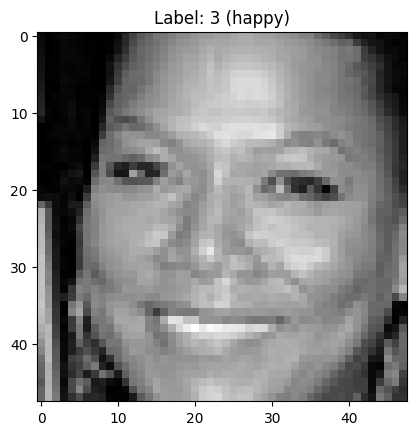

In [12]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

print(images[0].shape)      # torch.Size([1, 48, 48])
print(labels[0])            # 예: tensor(3)
plt.imshow(images[0].squeeze(0), cmap='gray')  # squeeze로 채널 제거
plt.title(f"Label: {labels[0].item()} ({train_data.classes[labels[0]]})")
plt.show()

In [13]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 6x6
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [15]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.5948
Epoch 2/10, Loss: 1.3152
Epoch 3/10, Loss: 1.1899
Epoch 4/10, Loss: 1.0883
Epoch 5/10, Loss: 0.9864
Epoch 6/10, Loss: 0.8953
Epoch 7/10, Loss: 0.7954
Epoch 8/10, Loss: 0.6933
Epoch 9/10, Loss: 0.6006
Epoch 10/10, Loss: 0.5201


In [16]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 59.42%


In [17]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=train_data.classes))


              precision    recall  f1-score   support

       angry       0.45      0.56      0.50       958
     disgust       0.86      0.45      0.59       111
        fear       0.49      0.44      0.46      1024
       happy       0.80      0.78      0.79      1774
     neutral       0.54      0.53      0.53      1233
         sad       0.45      0.46      0.46      1247
    surprise       0.79      0.74      0.76       831

    accuracy                           0.59      7178
   macro avg       0.63      0.57      0.58      7178
weighted avg       0.60      0.59      0.60      7178



In [2]:
# LR 스케쥴러 사용

import math
import torch
from torch.optim.lr_scheduler import LRScheduler

class CosineAnnealing_WarmRestartsLR(LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer, #사용할 최적화 함수
        warmup_steps: int = 128, #초기단계 스텝
        cycle_steps: int = 512, #한 사이클에 들어가는 전체 스탭 수
        min_lr: float = 0, #최소 학습률
        max_lr: float = 1e-3, #최대 학습률
    ): #초기 128스텝 까지 증가하고 이후 512 스텝마다 코사인 주기로 반복
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.cycle_steps = cycle_steps
        self.min_lr = min_lr
        self.max_lr = max_lr
        
        self.steps_counter = 0 #학습 중 스텝이 얼마나 진행되었는지 저장하는 변수
        
        super().__init__(optimizer) #부모 클래스인 LRS의 초기화 함수 호출
        
    
    def step(self,epoch = None):
        self.steps_counter+=1
        
        current_cyclestep =  self.steps_counter % self.cycle_steps #매 스탭마다 현재 스탭을 확인
        
        if (current_cyclestep < self.warmup_steps):
            current_lr = self.min_lr 
            + (self.max_lr - self.min_lr) * (current_cyclestep / self.warmup_steps)
        # 초기 스탭일 경우에는 학습률이 점차 크게 변화
        
        else:
            current_lr = current_lr = self.min_lr 
            + (self.max_lr - self.min_lr) *(
                1 + math.cos(math.pi * (current_cyclestep - self.warmup_steps)
                / (self.cycle_steps - self.warmup_steps)
                )) / 2
        #cosine annealing 적용 : 부드럽게 감소시켜 최 저점까지 적용시킨다
        #cos이 0 ~ 180도 까지의 값을 가진다 == 1 ~ -1 : 스텝 초기는 1, 후기는 -1
        # 1+ ~~ / 2를 통해 cos이 1이면 1+1/2 = 1, 0이면 1-1/2 = 0로 부드럽게 최저점에 도달할 수 있다
    
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = current_lr

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torchvision.ops import StochasticDepth

model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_tiny_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth",
    "convnext_small_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

class SE_Layer(nn.Module): #Squeeze and Excitation 층
    def __init__(self, channel, reduction = 16): #입력  태널 수와 축소 비율을 받아와서 초기화
        super(SE_Layer, self).__init__()
        
        self.avg_pool = nn.AdaptiveMaxPool2d(1) #B,C,H,W를 B,C,1,1로 만든다. (1인 이유는 인자 값)
        
        self.fc = nn.Sequential(
            nn.Linear(channel,channel // reduction, bias=False),
            #chennel 에서 chennel / reduction 로 채널 수 압축
            nn.ReLU(inplace = True),
            #비선형 활성화
            nn.Linear(channel//reduction, channel, bias = False),
            # channel / reduction 에서 channel로 차원 복원
            nn.Sigmoid(),
            # 채널 중요도를 0 ~ 1 사이로 정규화
        )
    
    def forward(self, x):
        b, c, _, _ = x.size() #입력 이미지의 배치와 채널만 본다
        y = self.avg_pool(x).view(b, c) #x를 채널별로 평균값만 추출하여 B,C로 변형 == 각 채널마다 대푯값 하나씩만 남김
        y = self.fc(y).view(b,c,1,1) #fc 레이어를 통과시켜서 각 채널의 중요도(가중치)를 계산, 다시 B,C,1,1로 변형해서 곱셈 가늘
        return x * y.expand_as(x) #입력 이미지 x에 채널별로 y를 곱셈 --- 중요도가 크면 강조, 작으면 억제

# 그래서 얜 뭘하는 걸까?
# 이미지를 입력 받아서 채널 별 평균으로 각 채널의 대푯값을 구하고, 그 값을 FC에 넣어서 채널별 가중치를 학습해
# 중요한건 해당 가중치가 MLP 역전파를 통해 업데이트 되면서 점차 값이 올바르게 바뀌어 나간다는거
# 아마 또 편미분하고 그 값 기반으로 업데이트 하고, 그냥 최적화 GD랑 동일한 과정일것으로 예상된다 

class DotProductSelfAttention(nn.Module): #내적 점곱(DotProduct Self-Attention) 처리
    def __init__(self, input_dim): # 입력 특징 차원 수를 입력으로 받아 초기화
        super(DotProductSelfAttention, self).__init__()
        self.input_dim = input_dim 
        self.norm = nn.LayerNorm(input_dim) #입력 x를 정규화 하는 메서드
        self.query = nn.Linear(input_dim, input_dim) # Q(Query)를 만드는 선형 레이어
        self.key = nn.Linear(input_dim, input_dim) # K(Key)를 만드는 선형 레이어
        self.value = nn.Linear(input_dim, input_dim) # V(Value)를 만드는 선형 레이어

    def forward(self, x):
        x = self.norm(x) #입력 x를 정규화
        query = self.query(x) #정규화 한 X를 집어넣어 Q,K,V를 계산
        key = self.key(x)
        value = self.value(x)

        scale = 1 / math.sqrt(math.sqrt(self.input_dim)) #입력 차원에 따라 정규화 (크기 조정)
        scores = torch.matmul(query, key.transpose(-2, -1)) * scale #Q X K_t 계산 => 결과 : 각 위치간 유사도 행렬
        #코드는그냥 마지막 2 층을 서로 바꿔버린다는 의미
        attention_weights = torch.softmax(scores, dim=-1) #어텐션 가중치를 소프트맥스에 따라 정규화

        attended_values = torch.matmul(attention_weights, value) #어텐션 가중치에 V를 곱하여 중요 정보를 반영한 결과 생성 
        output = attended_values + x #잔차 연결

        return output, attention_weights #어텐션 가중치값과 잔차연결 된 이미지 출력

# 코드 자체로는 일반적인 어텐션이랑 다를게 없는 듯
# 중요하게 판단할 점은 Q,K,V 가 선형 레이어를 거쳐서 만들어진다는거. 즉 학습된다

class LayerNorm(nn.Module):
    r"""LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """ # 해당 LayerNorm은 탠서가 마지막에 있는 포맷이든, (B,H,W,C) 앞에 있는 포맷이든 둘다 처리 가능하다

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        #정규화할 차원의 크기를 입력받으며 초기화 
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape)) # 정규화 출력에 곱해질 가중치 설정 (초기값 1)
        self.bias = nn.Parameter(torch.zeros(normalized_shape)) #정규화 출력에 더해질 바이어스 설정 (초기값 0)
        self.eps = eps #매우 작은 크기의 숫자 (앱실론) 설정
        self.data_format = data_format #입력 데이터 포맷 설정
        if self.data_format not in ["channels_last", "channels_first"]:
            # 정해진 입력 데이터 포맷을 따르지 않는 데이터가 입력되었을 경우
            raise NotImplementedError #예외 발생
        self.normalized_shape = (normalized_shape,) #튜플의 형태로 저장

    def forward(self, x): #데이터 포맷의 형태가 Channels_last라면 
        if self.data_format == "channels_last": # (N,H,W,C)
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            ) #Pytorch의 내장 F.Layer_Norm으로 정규화 수행
        elif self.data_format == "channels_first": #Channel_First라면, (N,C,H,W)
            u = x.mean(1, keepdim=True) #채널 방향 (dim =1)로 평균값 계산 : 2번째 차원이여서 1
            s = (x - u).pow(2).mean(1, keepdim=True) #분산 계산
            x = (x - u) / torch.sqrt(s + self.eps) #입력 데이터의 정규화 수행
            x = self.weight[:, None, None] * x + self.bias[:, None, None] #가중치와 바이어스를 곱하고 더하기
            return x

    # 왜 따로 이렇게 만들었을까? Pytorch의 내장 함수 쓰지않고?
    # 유지보수성이라든가, 성능 향상적 측면에서 효율적일 수 있기 때문
    
class Block(nn.Module):
    r"""ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    #ConvNeXt 블록 : 2가지 방식으로 동일하게 구현이 가능하다.
    #DwConv -> LayerNorm (Channels_First) -> 1x1 Conv -> GELU -> 1x1 Conv : 모든 연산을 (N,C,H,W)포맷에서 수행
    #DwConv -> (N, H, W, C) 형태로 변환 -> LayerNorm (channels_last) -> Linear -> GELU -> Linear -> 다시 원래 형태로 변환
    #2번 방식이 좀 더 빨라서 2번을 사용한다
    
    #궁금 1. 왜 2번은 Linear로 Conv로 대체했을까?
    #1x1 Conv는 공간을 건드리지 않고 채널 간 변환만 하므로 (H,W)는 그대로 두되 C만 변환하는 Linear과 동일하게 작동할 수 있다

    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__() 
        #dim = 입력 채널 수, Stochastic Depth 비율 : 블록을 확률적으로 생략하는 비율, Local_Scale 초기값
        self.dwconv = nn.Conv2d(
            dim, dim, kernel_size=7, padding=3, groups=dim
        )  # depthwise conv : 채널마다 독립적인 Convolution 수행, 7x7커널을 사용하며 채널수는 유지, 출력 크기를 입력과 동일하게 유지
        # Depthwise Conv란? Xception에서 제시되었던 컨셉의 Conv, 채널별로 독립적인 Conv연산을 수행한다
        # 결과적인 채널 수는 동일하다
        self.norm = LayerNorm(dim, eps=1e-6) # 입력 텐서의 채널 방향에 대해 레이어 정규화 수행 
        self.pwconv1 = nn.Linear(
            dim, 4 * dim
        )  # pointwise/1x1 convs, implemented with linear layers : Pointwise 1x1 Conv 수행
        self.act = nn.GELU() #비선형 활성화 GELU 적용
        self.pwconv2 = nn.Linear(4 * dim, dim) #다시 Pointwise 1x1 Conv 수행 (원래대로 축소)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )#dim 차원만큼 각 채널에 Scale을 곱, 아주 작은 값에서 시작하여 학습하면서 커진다
        #이는 잔차블록의 역할
        self.stochastic_depth = StochasticDepth(drop_path, "row")
        # drop_path의 확률에 따라 블록을 통째로 skip할 수 있다
        #(= 배치 단위가 아닌 sample(행)단위로 drop 여부를 결정한다

    def forward(self, x): # 순전파 기준
        input = x # 입력 데이터 x
        x = self.dwconv(x) # 1x1 Conv
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x) 
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None: # 
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.stochastic_depth(x)
        return x

class EmoNeXt(nn.Module):
    def __init__(
        self,
        in_chans=3, # 입력 이미지의 채널 수
        num_classes=1000, #출력 클래스의 수 = 1000개
        depths=None, # 각 stage에서의 블록의 개수를 정의
        dims=None, # 각 stage에서의 차원 크기 리스트
        drop_path_rate=0.0, # Stochastic Depth를 적용할 확률
        layer_scale_init_value=1e-6, # LayersCALE 시의 초기값
    ):
        super().__init__()

        if dims is None:
            dims = [96, 192, 384, 768]
        if depths is None:
            depths = [3, 3, 9, 3]

        # localization-network 정의
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 52 * 52, 32), nn.ReLU(True), nn.Linear(32, 3 * 2)
        )
        # STN 과정(Affine 변환)을 위한 변환 행렬 theta를 예측하는 Localization Head
        
        self.downsample_layers = (
            nn.ModuleList()
        )  # 여러 스테이지를 담을 모듈 리스트 선언
        
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
        ) # 초기 해상도 감소 및 채널 정규화
        
        self.downsample_layers.append(stem) #stage로 추가
        
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"), #이전 출력 정규화
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2), #채널 수 증가
                SE_Layer(dims[i + 1]), #채널의 어텐션 매커니증 적용
            )
            self.downsample_layers.append(downsample_layer) #stage 추가

        self.stages = (
            nn.ModuleList()
        )  #스테이지를 담을 모듈리스트를 선언 2
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        #전체 블록 수 만큼 Stochastic Depth 확률을 고르게 생성한다
        # 깊은 블록일수록 더 자주 skip 되게 설정 -> 왜? 과적합 방지와 학습 안정화의 효력
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[
                    Block(
                        dim=dims[i], # 현재 stage의 채널 수
                        drop_path=dp_rates[cur + j], # 현재 Block에 해당하는 drop_path 확률
                        layer_scale_init_value=layer_scale_init_value, #초기 값
                    )
                    for j in range(depths[i]) #각 stage 별로 블록 개수 설정해서 stage 하나로 만든다
                ]
            )
            self.stages.append(stage)
            cur += depths[i] #다음 stage의 dp_rates 인덱스를 맞추기 위해 현재 Block 수만큼 더하기
            
        # 96채널 3개 192채널 3개 384채널 9개 768채널 3개 로 구설
        # 점점 고차원의 특징을 학습한다    
        
        #최종 채널 축[-1]에 대해 정규화와 어텐션 수행
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.attention = DotProductSelfAttention(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
        # 모델 내의 모든 서브 모듈을 순회하여 가중치 초기화와 바이어스 초기화 진행

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
        # STN 변환을 위한 Affine 변환 행렬 초기화
        # STN에서는 항등 행렬을 사용하여 처음에 아무 변화 없이 이미지가 전달되도록 보장된다
        )
        
        #해당 초기화는 모델 실행 시에 한번만 실행되는 초기화 코드

    def stn(self, x): #STN : 이미지를 적다하게 조절하여 잘 인식하게끔 만드는 과정
        xs = self.localization(x) #Localization으로 특징맵을 추출
        xs = xs.view(-1, 10 * 52 * 52) # 2D텐서로 펼침
        theta = self.fc_loc(xs) # 변환행렬 Theta를 예측하여 대입
        theta = theta.view(-1, 2, 3)
 
        grid = F.affine_grid(theta, x.size(), align_corners=True) #STN을 위해 이미지를 변환시킬 픽셀위치좌표계 생성
        x = F.grid_sample(x, grid, align_corners=True) # 만들어진 grid에 따라 입력 이미지 이동(샘플링 및 보간) 

        return x

    def forward_features(self, x): #순방향 처리 과정
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(
            x.mean([-2, -1]) 
        )  # global average pooling, (N, C, H, W) -> (N, C)
        
    # 최종 결과물은 특징벡터를 뽑아낸다

    def forward(self, x, labels=None): #순방향
        x = self.stn(x) #STN 과정
        x = self.forward_features(x) #특징 추출
        _, weights = self.attention(x) # 가중치 추출
        logits = self.head(x) #확률기반 예측

        if labels is not None: #정답이 있으면 Loss 계산
            mean_attention_weight = torch.mean(weights)
            attention_loss = torch.mean((weights - mean_attention_weight) ** 2)

            loss = F.cross_entropy(logits, labels, label_smoothing=0.2) + attention_loss
            return torch.argmax(logits, dim=1), logits, loss

        return torch.argmax(logits, dim=1), logits